In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
import seaborn as sns

pd.set_option('float_format', '{:f}'.format)

In [4]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
         'marital_status', 'occupation', 'relationship', 'race', 'sex',
         'capital_gain', 'capital_loss', 'hours_per_week',
         'native_country', 'salary'
        ]
df = pd.read_csv('/content/adult.data', names=names)
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
'''
Explanation of the column 'fnlwgt':

| Description of fnlwgt (final weight)
|
| The weights on the CPS files are controlled to independent estimates of the
| civilian noninstitutional population of the US.  These are prepared monthly
| for us by Population Division here at the Census Bureau.  We use 3 sets of
| controls.
|  These are:
|          1.  A single cell estimate of the population 16+ for each state.
|          2.  Controls for Hispanic Origin by age and sex.
|          3.  Controls by Race, age and sex.
|
| We use all three sets of controls in our weighting program and "rake" through
| them 6 times so that by the end we come back to all the controls we used.
|
| The term estimate refers to population totals derived from CPS by creating
| "weighted tallies" of any specified socio-economic characteristics of the
| population.
|
| People with similar demographic characteristics should have
| similar weights.  There is one important caveat to remember
| about this statement.  That is that since the CPS sample is
| actually a collection of 51 state samples, each with its own
| probability of selection, the statement only applies within
| state.
'''

'\nExplanation of the column \'fnlwgt\':\n\n| Description of fnlwgt (final weight)\n|\n| The weights on the CPS files are controlled to independent estimates of the\n| civilian noninstitutional population of the US.  These are prepared monthly\n| for us by Population Division here at the Census Bureau.  We use 3 sets of\n| controls.\n|  These are:\n|          1.  A single cell estimate of the population 16+ for each state.\n|          2.  Controls for Hispanic Origin by age and sex.\n|          3.  Controls by Race, age and sex.\n|\n| We use all three sets of controls in our weighting program and "rake" through\n| them 6 times so that by the end we come back to all the controls we used.\n|\n| The term estimate refers to population totals derived from CPS by creating\n| "weighted tallies" of any specified socio-economic characteristics of the\n| population.\n|\n| People with similar demographic characteristics should have\n| similar weights.  There is one important caveat to remember\n|

In [61]:
df.head() # Missing values are '?'

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,salary_over_50k
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,0
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,0
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,45,1


In [7]:
df['workclass'][27] # Question mark has a leading space

' ?'

In [8]:
df = df.replace({' ?': np.nan})
df.loc[27,:]

age                                54
workclass                         NaN
fnlwgt                         180211
education                Some-college
education_num                      10
marital_status     Married-civ-spouse
occupation                        NaN
relationship                  Husband
race               Asian-Pac-Islander
sex                              Male
capital_gain                        0
capital_loss                        0
hours_per_week                     60
native_country                  South
salary                           >50K
Name: 27, dtype: object

In [9]:
df.describe(exclude='number')
# df.describe(exclude='number').columns

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
for col in df.describe(exclude='number').columns:
    df[col].replace({np.nan: 'Unknown'}, inplace=True)

In [11]:
df.describe(exclude='number')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [12]:
# From this data, we can see that there are columns containing values which are poorly
# distributed such as 'capital_gain', 'capital_loss' which, for the most part, are
# mostly 0s.  I think we might be able to curtail 'age' and 'hours_per_week' as well.

df.describe(exclude=['category', 'object'])

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [13]:
# For curtailing purposes, I would like to only see results from the United States
# since 29170 of the 32561 observations are for this location.

# The value United-States has a leading space

us_df = df[df['native_country']==' United-States']
us_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,187069.021152,10.169455,1089.229928,88.510593,40.447755
std,13.722408,104877.981749,2.394966,7381.898528,405.681709,12.417203
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,115895.250000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,176730.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,234138.500000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [14]:
# For the purposes of being consistant, I would keep the hours_per_week limited to
# 40 hours in a work week (avg = 39.2h in 1995) source: https://www.bls.gov/opub/mlr/1997/04/art1full.pdf

# Since 75% of the data is from 1-45, I'd like to make the max just above that at 50h

# At the other side, the government, in 1996, defined part time as working less than 30-35h
# per work week so, I will have the lower end be 30h

hour_mask = (us_df['hours_per_week']>=30) & (us_df['hours_per_week']<=50)

len(us_df['hours_per_week'][(us_df['hours_per_week']<30) & (us_df['hours_per_week']>50)])

0

In [0]:
hour_df = us_df[hour_mask]

In [16]:
# I chose 62 since, back in the early 90s, the early retirement age was 61 and, today
# it is now 62 (full 65-67).

age_mask = hour_df['age']<=62

print(len(hour_df['age'][hour_df['age']>62]))

848


In [0]:
age_df = hour_df[age_mask]

In [18]:
# Next I will drop trivial columns and columns with many 0s

df = age_df.drop(columns=['fnlwgt', 'capital_gain', 'capital_loss', 'native_country'])
df.shape

(21306, 11)

In [19]:
df.describe()

,age,education_num,hours_per_week
count,21306.000000,21306.000000,21306.000000
mean,37.572280,10.209659,40.971276
std,11.401522,2.300745,4.634546
min,17.000000,1.000000,30.000000
25%,28.000000,9.000000,40.000000
50%,37.000000,10.000000,40.000000
75%,46.000000,12.000000,40.000000
max,62.000000,16.000000,50.000000


In [20]:
df.describe(exclude='number')

,workclass,education,marital_status,occupation,relationship,race,sex,salary
count,21306,21306,21306,21306,21306,21306,21306,21306
unique,9,16,7,15,6,5,2,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,<=50K
freq,15443,7511,9832,3116,8707,18515,14359,15991


In [0]:
# This distribution tapers off at 500000 so I will have that be the limit.

# sns.distplot(df['fnlwgt']);

In [0]:
df['salary_over_50k'] = df['salary'].replace({' <=50K': 0, ' >50K': 1})

In [23]:
df['salary_over_50k'].value_counts(normalize=True)

0   0.750540
1   0.249460
Name: salary_over_50k, dtype: float64

In [24]:
df = df.drop(columns='salary')
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,salary_over_50k
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,0
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,0
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,45,1


In [25]:
train, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train, test_size=0.20, random_state=42)
print(train.shape, val.shape, test.shape)

(14488, 11) (3622, 11) (3196, 11)


In [0]:
target = 'salary_over_50k'
features = train.drop(columns=target).columns

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [27]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, w

In [28]:
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]
roc_auc_score(y_val, y_pred_proba)
# y_pred_proba

0.8335728062497975

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
(fpr, tpr, thresholds)

(array([0.        , 0.00368732, 0.00368732, 0.00368732, 0.00405605,
        0.00442478, 0.00442478, 0.00479351, 0.00663717, 0.00663717,
        0.0070059 , 0.00811209, 0.00811209, 0.00811209, 0.00811209,
        0.00811209, 0.00811209, 0.00884956, 0.00884956, 0.00884956,
        0.00958702, 0.01032448, 0.01143068, 0.01143068, 0.01143068,
        0.01179941, 0.01179941, 0.01179941, 0.0129056 , 0.01327434,
        0.01327434, 0.01327434, 0.0140118 , 0.0140118 , 0.01474926,
        0.01474926, 0.01511799, 0.01659292, 0.01659292, 0.01769912,
        0.01769912, 0.01769912, 0.01769912, 0.01843658, 0.01843658,
        0.01843658, 0.01843658, 0.01880531, 0.01917404, 0.01917404,
        0.01954277, 0.01954277, 0.0199115 , 0.0199115 , 0.0199115 ,
        0.02064897, 0.02064897, 0.0210177 , 0.02175516, 0.02175516,
        0.02212389, 0.02286136, 0.02323009, 0.02323009, 0.02359882,
        0.02396755, 0.02396755, 0.02470501, 0.02507375, 0.02507375,
        0.02581121, 0.02581121, 0.02581121, 0.02

Text(0, 0.5, 'True Positive Rate')

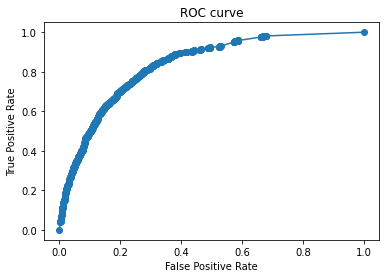

In [30]:
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

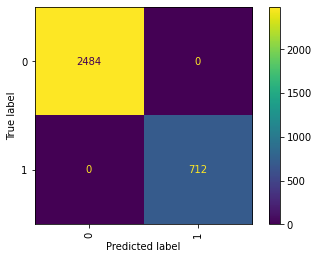

In [31]:
from sklearn.metrics import plot_confusion_matrix

y_pred = pipeline.predict(X_test)
plot_confusion_matrix(pipeline, X_test, y_pred, values_format='.0f', xticks_rotation='vertical');

In [32]:
transformers = make_pipeline(
    OrdinalEncoder() 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
permuter = PermutationImportance(
    model,
    scoring='roc_auc',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [34]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

education        -0.014025
race             -0.003611
workclass        -0.003192
sex               0.000452
hours_per_week    0.001342
occupation        0.008448
relationship      0.025167
marital_status    0.031050
education_num     0.033431
age               0.041921
dtype: float64

In [35]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0419 ± 0.0106,age
0.0334 ± 0.0079,education_num
0.0310 ± 0.0037,marital_status
0.0252 ± 0.0123,relationship
0.0084 ± 0.0059,occupation
0.0013 ± 0.0042,hours_per_week
0.0005 ± 0.0031,sex
-0.0032 ± 0.0045,workclass
-0.0036 ± 0.0028,race
-0.0140 ± 0.0033,education


In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance

features = X_train.columns[mask]
X_train = X_train[features]

In [37]:
!pip install category_encoders
import category_encoders as ce

X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

     |████████████████████████████████| 102kB 2.9MB/s 
Validation Accuracy 0.7948647156267256


In [38]:
features

Index(['age', 'education_num', 'marital_status', 'occupation', 'relationship',
       'sex', 'hours_per_week'],
      dtype='object')

In [39]:
plt.rcParams['figure.dpi'] = 72
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'hours_per_week'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    num_grid_points=50,
    feature=feature
)

     |████████████████████████████████| 57.7MB 59kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=ad4c7fe737e30ba4bf8ac4bf7b044e9dc836b872af8d55d9ad43343823527b3f
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


ERROR! Session/line number was not unique in database. History logging moved to new session 59


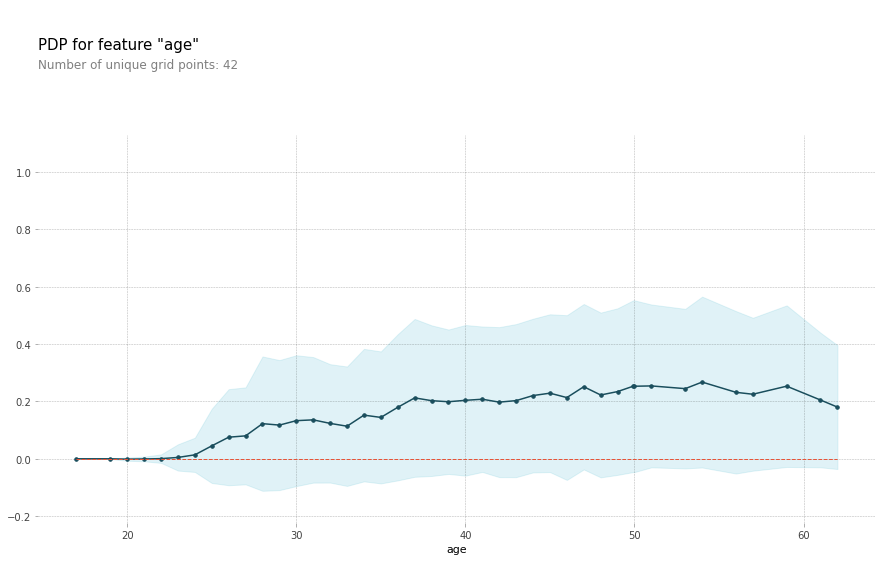

In [44]:
pdp_plot(isolated, feature_name=feature);

In [0]:
feature = 'age'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    num_grid_points=50,
    feature=feature
)

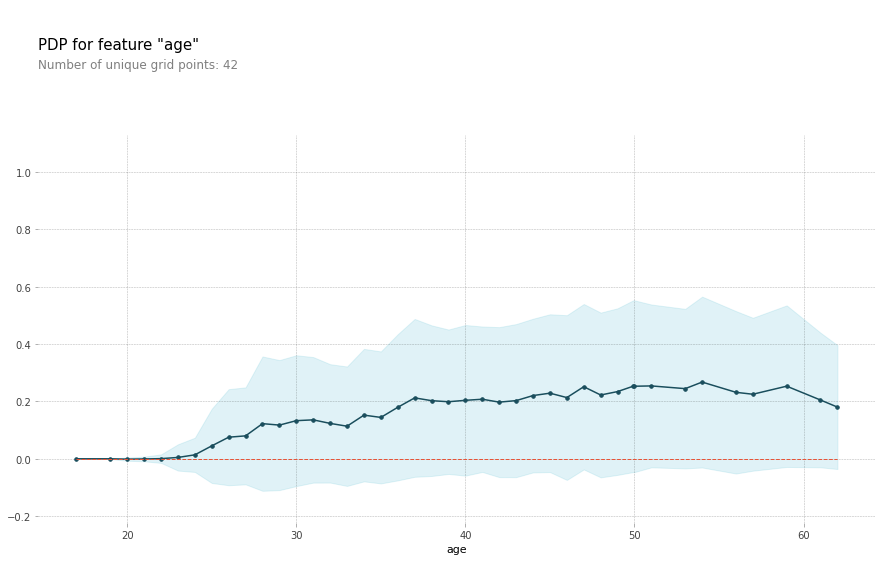

In [45]:
pdp_plot(isolated, feature_name=feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


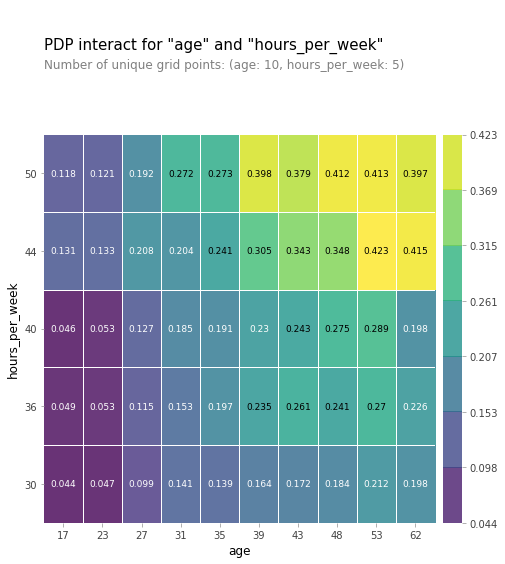

In [47]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['age', 'hours_per_week']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

# pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [54]:
!pip install shap
import shap


     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394108 sha256=10b463719459589dcf9e2d6cf41447edd127ba0e6678d09ee17e2f8ea4fa4d7d
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
